<a href="https://colab.research.google.com/github/JellePiepenbrock/neurosmash/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
from IPython.display import clear_output
import os, sys

drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/My Drive/projects/entity_tagging/')

base_url = '/content//gdrive/My Drive/projects/NIPS/'

clear_output()

## VAE

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=32):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=512, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )

        model_parameters = filter(lambda p: p.requires_grad, self.encoder.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print('Trainable parameters encoder: ', params)
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, 32)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )

        model_parameters = filter(lambda p: p.requires_grad, self.decoder.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print('Trainable parameters decoder: ', params)
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar


# vae = VAE(image_channels=3).to(device)
# optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim import Adam
from PIL import Image
import torch.nn.functional as F
import numpy as np
import torch
from torch.autograd import Variable
from torch.distributions import Categorical
from random import randint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image, to_grayscale, to_tensor

device = torch.device('cuda')
torch.manual_seed(42)
batch_size = 32

In [0]:
dataset = torch.load('{}/neurosmash/training_data.pt'.format(base_url))
dataset_flattened = np.array([np.transpose(x.data.numpy(), (1,2,0)) for x in dataset.reshape(-1, 3, 64, 64)])

In [0]:
backSub = cv2.createBackgroundSubtractorMOG2()
temp = np.uint8(dataset_flattened*255)[:10000]
    
for frame in temp:   
    frame = frame[0,:,:]
    fgMask = backSub.apply(frame)

filters = np.repeat(np.array([np.array(backSub.apply(np.uint8(x_*255))) for x_ in dataset_flattened]).reshape(-1, 1, 64, 64), 3, axis=1)
dataset_flattened = np.transpose(dataset_flattened, (0, 3, 1, 2))
dataset_flattened = np.array([np.array([x, f]) for x,f in zip(dataset_flattened, filters)])
dataset_flattened = torch.from_numpy(dataset_flattened).float() #/ 255
dataloader = torch.utils.data.DataLoader(dataset_flattened, batch_size=batch_size, shuffle=True)

Training new model with weights: 0
Trainable parameters encoder:  231200
Trainable parameters decoder:  43931
Loaded model.
Storing weights 7916.4340296875 9999999
Epoch 1, loss 247.38856342773437


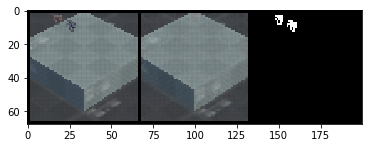

Storing weights 7888.952791796875 7916.4340296875
Epoch 2, loss 246.52977474365235
Storing weights 7888.072016015625 7888.952791796875
Epoch 3, loss 246.5022505004883
Storing weights 7887.550813671875 7888.072016015625
Epoch 4, loss 246.4859629272461
Storing weights 7887.11526171875 7887.550813671875
Epoch 5, loss 246.47235192871094
Storing weights 7886.801282421875 7887.11526171875
Epoch 6, loss 246.4625400756836


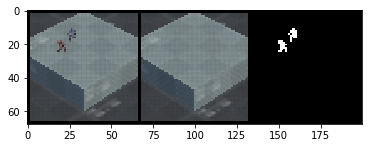

Storing weights 7886.6692234375 7886.801282421875
Epoch 7, loss 246.45841323242186
Storing weights 7886.380525390625 7886.6692234375
Epoch 8, loss 246.44939141845703
Storing weights 7886.301728515625 7886.380525390625
Epoch 9, loss 246.44692901611327
Storing weights 7886.2589171875 7886.301728515625
Epoch 10, loss 246.44559116210937
Storing weights 7886.229923046875 7886.2589171875
Epoch 11, loss 246.44468509521485


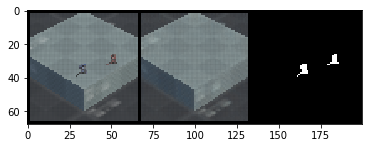

Storing weights 7886.205975 7886.229923046875
Epoch 12, loss 246.44393671875
Storing weights 7886.1912328125 7886.205975
Epoch 13, loss 246.44347602539062
Storing weights 7886.174053125 7886.1912328125
Epoch 14, loss 246.44293916015624
Storing weights 7886.15926796875 7886.174053125
Epoch 15, loss 246.44247712402344
Storing weights 7886.147121484375 7886.15926796875
Epoch 16, loss 246.44209754638672


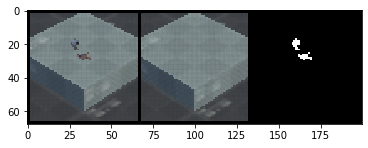

Storing weights 7886.13839765625 7886.147121484375
Epoch 17, loss 246.44182492675782
Storing weights 7886.129713671875 7886.13839765625
Epoch 18, loss 246.4415535522461
Storing weights 7886.119146875 7886.129713671875
Epoch 19, loss 246.44122333984376
Storing weights 7886.1143875 7886.119146875
Epoch 20, loss 246.441074609375
Storing weights 7886.108516015625 7886.1143875
Epoch 21, loss 246.4408911254883


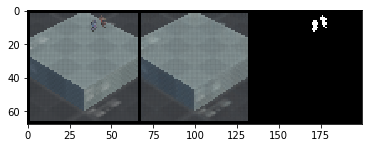

Storing weights 7886.099077734375 7886.108516015625
Epoch 22, loss 246.44059617919922
Storing weights 7886.090848828125 7886.099077734375
Epoch 23, loss 246.4403390258789
Storing weights 7886.079191015625 7886.090848828125
Epoch 24, loss 246.43997471923828
Storing weights 7886.075786328125 7886.079191015625
Epoch 25, loss 246.4398683227539
Storing weights 7886.06950078125 7886.075786328125
Epoch 26, loss 246.43967189941407


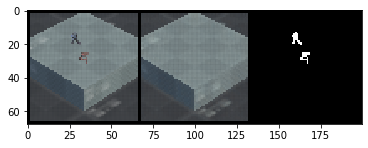

Storing weights 7886.0661375 7886.06950078125
Epoch 27, loss 246.439566796875
Storing weights 7886.0622421875 7886.0661375
Epoch 28, loss 246.43944506835936
Storing weights 7886.057129296875 7886.0622421875
Epoch 29, loss 246.43928529052735
Storing weights 7886.04550234375 7886.057129296875
Epoch 30, loss 246.43892194824218
Storing weights 7886.04208671875 7886.04550234375
Epoch 31, loss 246.43881520996095


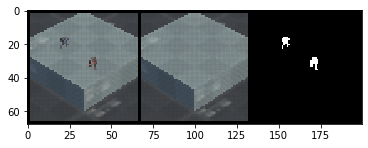

Storing weights 7886.037936328125 7886.04208671875
Epoch 32, loss 246.43868551025392
Storing weights 7886.031959375 7886.037936328125
Epoch 33, loss 246.43849873046875
Storing weights 7886.0292265625 7886.031959375
Epoch 34, loss 246.43841333007813
Storing weights 7886.022845703125 7886.0292265625
Epoch 35, loss 246.43821392822267
Storing weights 7886.01944765625 7886.022845703125
Epoch 36, loss 246.43810773925782


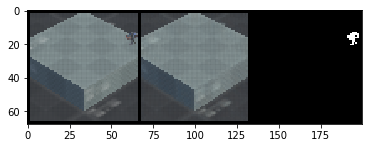

Storing weights 7886.01449453125 7886.01944765625
Epoch 37, loss 246.43795295410158
Storing weights 7886.00946875 7886.01449453125
Epoch 38, loss 246.4377958984375
Storing weights 7886.0067296875 7886.00946875
Epoch 39, loss 246.4377103027344
Storing weights 7886.00349296875 7886.0067296875
Epoch 40, loss 246.43760915527344
Storing weights 7886.001706640625 7886.00349296875
Epoch 41, loss 246.43755333251954


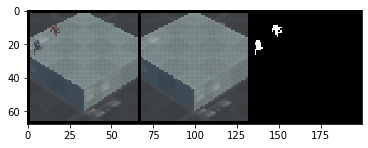

Storing weights 7885.995451953125 7886.001706640625
Epoch 42, loss 246.43735787353515
Storing weights 7885.991130859375 7885.995451953125
Epoch 43, loss 246.43722283935546
Storing weights 7885.986884765625 7885.991130859375
Epoch 44, loss 246.4370901489258
Storing weights 7885.979137890625 7885.986884765625
Epoch 45, loss 246.43684805908202
Storing weights 7885.973375 7885.979137890625
Epoch 46, loss 246.43666796875


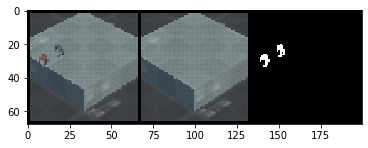

Storing weights 7885.971058203125 7885.973375
Epoch 47, loss 246.43659556884765
Storing weights 7885.96681640625 7885.971058203125
Epoch 48, loss 246.4364630126953
Storing weights 7885.9643015625 7885.96681640625
Epoch 49, loss 246.43638442382812
Storing weights 7885.959834375 7885.9643015625
Epoch 50, loss 246.43624482421876
Storing weights 7885.95743125 7885.959834375
reducing lr
Epoch 51, loss 246.4361697265625


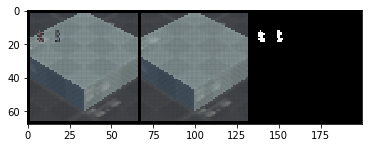

Storing weights 7885.9102265625 7885.95743125
Epoch 52, loss 246.43469458007812
Storing weights 7885.908703125 7885.9102265625
Epoch 53, loss 246.43464697265625
Storing weights 7885.90755625 7885.908703125
Epoch 54, loss 246.4346111328125
Storing weights 7885.905944140625 7885.90755625
Epoch 55, loss 246.43456075439454
Storing weights 7885.903101953125 7885.905944140625
Epoch 56, loss 246.43447193603515


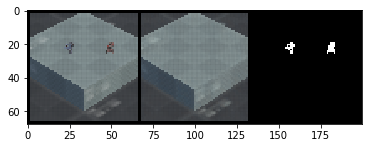

Storing weights 7885.900548828125 7885.903101953125
Epoch 57, loss 246.4343921508789
Storing weights 7885.8982203125 7885.900548828125
Epoch 58, loss 246.43431938476562
Storing weights 7885.89641953125 7885.8982203125
Epoch 59, loss 246.43426311035157
Storing weights 7885.894882421875 7885.89641953125
Epoch 60, loss 246.4342150756836
Storing weights 7885.893187109375 7885.894882421875
Epoch 61, loss 246.43416209716796


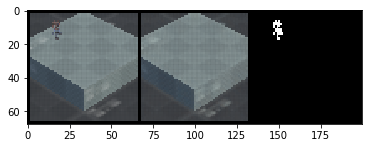

Storing weights 7885.892159765625 7885.893187109375
Epoch 62, loss 246.4341299926758
Storing weights 7885.890804296875 7885.892159765625
Epoch 63, loss 246.43408763427735
Storing weights 7885.889515234375 7885.890804296875
Epoch 64, loss 246.4340473510742
Storing weights 7885.888551171875 7885.889515234375
Epoch 65, loss 246.4340172241211
Storing weights 7885.88763203125 7885.888551171875
Epoch 66, loss 246.43398850097657


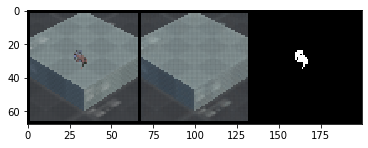

Storing weights 7885.88691484375 7885.88763203125
Epoch 67, loss 246.43396608886718
Storing weights 7885.88593828125 7885.88691484375
Epoch 68, loss 246.43393557128906
Storing weights 7885.885187109375 7885.88593828125
Epoch 69, loss 246.43391209716796
Storing weights 7885.884521484375 7885.885187109375
Epoch 70, loss 246.43389129638672
Storing weights 7885.883657421875 7885.884521484375
Epoch 71, loss 246.4338642944336


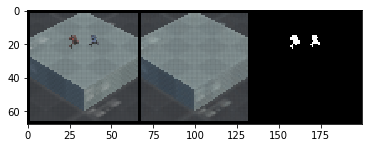

Storing weights 7885.8829046875 7885.883657421875
Epoch 72, loss 246.43384077148437
Storing weights 7885.8822078125 7885.8829046875
Epoch 73, loss 246.43381899414064
Storing weights 7885.881355078125 7885.8822078125
Epoch 74, loss 246.4337923461914
Storing weights 7885.881032421875 7885.881355078125
Epoch 75, loss 246.4337822631836
Storing weights 7885.88032421875 7885.881032421875
Epoch 76, loss 246.43376013183592


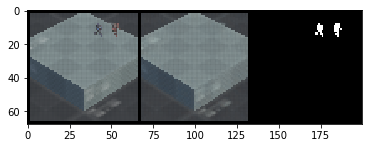

Storing weights 7885.879553125 7885.88032421875
Epoch 77, loss 246.43373603515624
Storing weights 7885.8792765625 7885.879553125
Epoch 78, loss 246.43372739257813
Storing weights 7885.878590625 7885.8792765625
Epoch 79, loss 246.43370595703124
Storing weights 7885.87812734375 7885.878590625
Epoch 80, loss 246.43369147949218
Storing weights 7885.877694140625 7885.87812734375
Epoch 81, loss 246.43367794189453


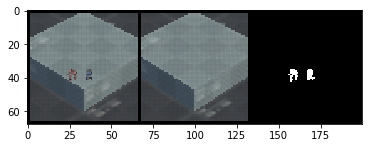

Storing weights 7885.87710859375 7885.877694140625
Epoch 82, loss 246.43365964355468
Storing weights 7885.8769453125 7885.87710859375
Epoch 83, loss 246.4336545410156
Storing weights 7885.8764359375 7885.8769453125
Epoch 84, loss 246.43363862304687
Storing weights 7885.876030859375 7885.8764359375
Epoch 85, loss 246.43362596435546
Storing weights 7885.875481640625 7885.876030859375
Epoch 86, loss 246.43360880126954


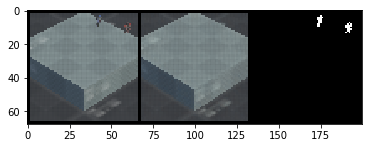

Storing weights 7885.875405859375 7885.875481640625
Epoch 87, loss 246.43360643310547
Storing weights 7885.875026953125 7885.875405859375
Epoch 88, loss 246.43359459228515
Storing weights 7885.87438125 7885.875026953125
Epoch 89, loss 246.4335744140625
Storing weights 7885.8742921875 7885.87438125
Epoch 90, loss 246.43357163085938
Storing weights 7885.87392734375 7885.8742921875
Epoch 91, loss 246.4335602294922


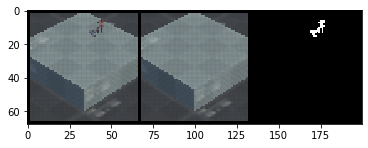

Storing weights 7885.87358046875 7885.87392734375
Epoch 92, loss 246.43354938964845
Storing weights 7885.87332421875 7885.87358046875
Epoch 93, loss 246.43354138183594
Storing weights 7885.8728984375 7885.87332421875
Epoch 94, loss 246.43352807617188
Storing weights 7885.8725390625 7885.8728984375
Epoch 95, loss 246.43351684570314
Storing weights 7885.871894140625 7885.8725390625
Epoch 96, loss 246.43349669189453


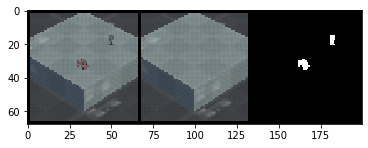

Storing weights 7885.87144296875 7885.871894140625
Epoch 97, loss 246.43348259277343
Storing weights 7885.87122890625 7885.87144296875
Epoch 98, loss 246.4334759033203
Storing weights 7885.8708640625 7885.87122890625
Epoch 99, loss 246.43346450195313
Storing weights 7885.87055 7885.8708640625
Epoch 100, loss 246.4334546875
Storing weights 7885.870388671875 7885.87055
reducing lr
Epoch 101, loss 246.4334496459961


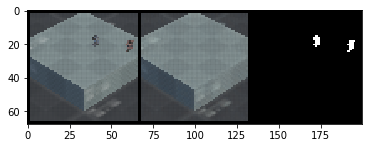

Storing weights 7885.864271484375 7885.870388671875
Epoch 102, loss 246.43325848388673
Storing weights 7885.86398828125 7885.864271484375
Epoch 103, loss 246.43324963378907
Storing weights 7885.8639546875 7885.86398828125
Epoch 104, loss 246.43324858398438
Epoch 105, loss 246.43324864501952
Storing weights 7885.86386953125 7885.8639546875
Epoch 106, loss 246.43324592285157


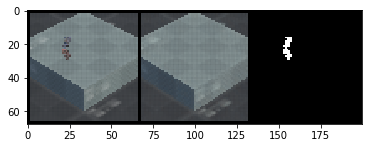

Storing weights 7885.863853125 7885.86386953125
Epoch 107, loss 246.43324541015625
Storing weights 7885.8638 7885.863853125
Epoch 108, loss 246.43324375
Storing weights 7885.8637375 7885.8638
Epoch 109, loss 246.433241796875
Storing weights 7885.863669140625 7885.8637375
Epoch 110, loss 246.43323966064452
Epoch 111, loss 246.43323978271485


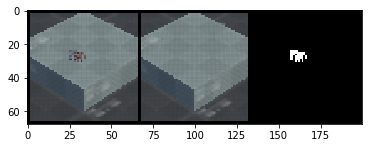

Storing weights 7885.863614453125 7885.863669140625
Epoch 112, loss 246.43323795166015
Storing weights 7885.863454296875 7885.863614453125
Epoch 113, loss 246.43323294677734
Storing weights 7885.863388671875 7885.863454296875
Epoch 114, loss 246.4332308959961
Storing weights 7885.86329375 7885.863388671875
Epoch 115, loss 246.4332279296875
Storing weights 7885.863244921875 7885.86329375
Epoch 116, loss 246.4332264038086


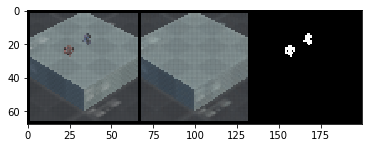

Storing weights 7885.863169140625 7885.863244921875
Epoch 117, loss 246.43322403564454
Storing weights 7885.8631296875 7885.863169140625
Epoch 118, loss 246.43322280273438
Storing weights 7885.863048828125 7885.8631296875
Epoch 119, loss 246.4332202758789
Storing weights 7885.86298671875 7885.863048828125
Epoch 120, loss 246.43321833496094
Storing weights 7885.862923046875 7885.86298671875
Epoch 121, loss 246.43321634521484


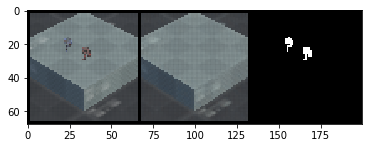

Storing weights 7885.86286171875 7885.862923046875
Epoch 122, loss 246.43321442871093
Storing weights 7885.86276171875 7885.86286171875
Epoch 123, loss 246.43321130371095
Storing weights 7885.86273828125 7885.86276171875
Epoch 124, loss 246.43321057128907
Storing weights 7885.862683984375 7885.86273828125
Epoch 125, loss 246.4332088745117
Storing weights 7885.862605859375 7885.862683984375
Epoch 126, loss 246.43320643310548


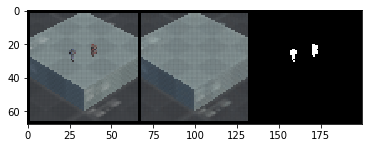

Storing weights 7885.862554296875 7885.862605859375
Epoch 127, loss 246.43320482177734
Storing weights 7885.862483203125 7885.862554296875
Epoch 128, loss 246.43320260009764
Storing weights 7885.862424609375 7885.862483203125
Epoch 129, loss 246.43320076904297
Storing weights 7885.862357421875 7885.862424609375
Epoch 130, loss 246.43319866943358
Storing weights 7885.86230703125 7885.862357421875
Epoch 131, loss 246.43319709472655


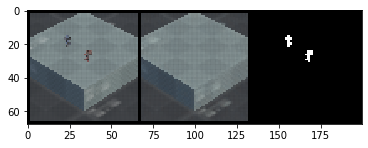

Storing weights 7885.86229765625 7885.86230703125
Epoch 132, loss 246.43319680175782
Storing weights 7885.86218125 7885.86229765625
Epoch 133, loss 246.4331931640625
Storing weights 7885.862124609375 7885.86218125
Epoch 134, loss 246.43319139404298
Storing weights 7885.86206875 7885.862124609375
Epoch 135, loss 246.4331896484375
Storing weights 7885.862046875 7885.86206875
Epoch 136, loss 246.43318896484374


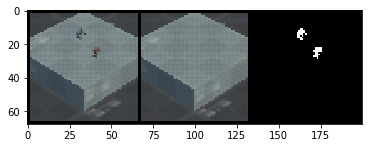

Storing weights 7885.86193125 7885.862046875
Epoch 137, loss 246.4331853515625
Storing weights 7885.861810546875 7885.86193125
Epoch 138, loss 246.43318157958984
Storing weights 7885.861746484375 7885.861810546875
Epoch 139, loss 246.4331795776367
Storing weights 7885.861671875 7885.861746484375
Epoch 140, loss 246.43317724609375
Storing weights 7885.86157578125 7885.861671875
Epoch 141, loss 246.43317424316407


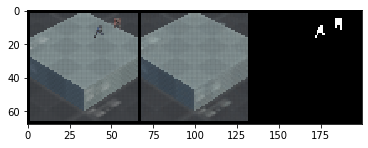

Storing weights 7885.861519140625 7885.86157578125
Epoch 142, loss 246.43317247314454
Storing weights 7885.86147109375 7885.861519140625
Epoch 143, loss 246.4331709716797
Storing weights 7885.8613765625 7885.86147109375
Epoch 144, loss 246.4331680175781
Storing weights 7885.861336328125 7885.8613765625
Epoch 145, loss 246.4331667602539
Storing weights 7885.861249609375 7885.861336328125
Epoch 146, loss 246.43316405029296


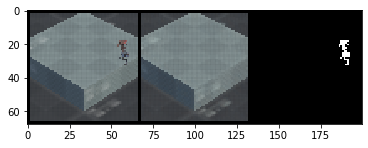

Storing weights 7885.86119375 7885.861249609375
Epoch 147, loss 246.4331623046875
Storing weights 7885.861065234375 7885.86119375
Epoch 148, loss 246.43315828857422
Storing weights 7885.861023046875 7885.861065234375
Epoch 149, loss 246.43315697021484
Storing weights 7885.861011328125 7885.861023046875
Epoch 150, loss 246.4331566040039
Training new model with weights: 1
Trainable parameters encoder:  231200
Trainable parameters decoder:  43931
Loaded model.
Storing weights 4354.299711328125 7885.861011328125
Epoch 1, loss 136.07186597900392


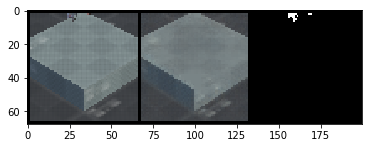

Storing weights 4338.861233203125 4354.299711328125
Epoch 2, loss 135.58941353759766
Storing weights 4338.04315 4338.861233203125
Epoch 3, loss 135.5638484375
Storing weights 4337.670292578125 4338.04315
Epoch 4, loss 135.5521966430664
Storing weights 4337.459638671875 4337.670292578125
Epoch 5, loss 135.5456137084961
Storing weights 4337.1723890625 4337.459638671875
Epoch 6, loss 135.53663715820312


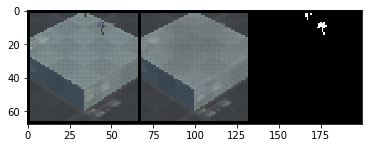

Storing weights 4333.643061328125 4337.1723890625
Epoch 7, loss 135.42634566650392
Storing weights 4323.82703046875 4333.643061328125
Epoch 8, loss 135.11959470214845
Storing weights 4320.523771875 4323.82703046875
Epoch 9, loss 135.01636787109376
Storing weights 4318.980449609375 4320.523771875
Epoch 10, loss 134.96813905029296
Storing weights 4318.054491796875 4318.980449609375
Epoch 11, loss 134.93920286865233


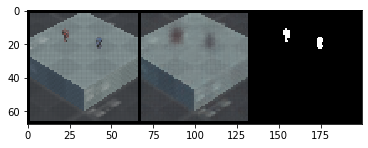

Storing weights 4317.413616796875 4318.054491796875
Epoch 12, loss 134.91917552490236
Storing weights 4316.92252578125 4317.413616796875
Epoch 13, loss 134.90382893066408
Storing weights 4316.617083203125 4316.92252578125
Epoch 14, loss 134.89428385009765
Storing weights 4316.335790234375 4316.617083203125
Epoch 15, loss 134.88549344482422
Storing weights 4316.13293203125 4316.335790234375
Epoch 16, loss 134.87915412597656


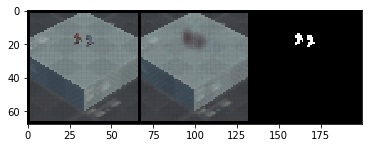

Storing weights 4316.02982421875 4316.13293203125
Epoch 17, loss 134.87593200683594
Storing weights 4315.855525390625 4316.02982421875
Epoch 18, loss 134.87048516845704
Storing weights 4315.72899609375 4315.855525390625
Epoch 19, loss 134.86653112792968
Storing weights 4315.602398828125 4315.72899609375
Epoch 20, loss 134.8625749633789
Storing weights 4315.52468671875 4315.602398828125
Epoch 21, loss 134.86014645996093


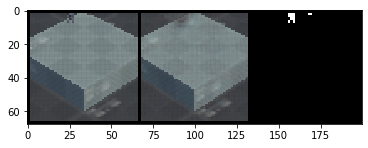

Storing weights 4315.433485546875 4315.52468671875
Epoch 22, loss 134.85729642333985
Storing weights 4315.35630625 4315.433485546875
Epoch 23, loss 134.8548845703125
Storing weights 4315.283771484375 4315.35630625
Epoch 24, loss 134.85261785888673
Storing weights 4315.209987890625 4315.283771484375
Epoch 25, loss 134.85031212158202
Storing weights 4315.17458515625 4315.209987890625
Epoch 26, loss 134.8492057861328


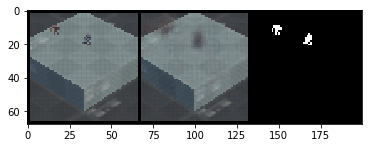

Storing weights 4315.113266015625 4315.17458515625
Epoch 27, loss 134.8472895629883
Storing weights 4315.06512734375 4315.113266015625
Epoch 28, loss 134.84578522949218
Storing weights 4315.02363125 4315.06512734375
Epoch 29, loss 134.8444884765625
Storing weights 4314.9590046875 4315.02363125
Epoch 30, loss 134.84246889648438
Storing weights 4314.932438671875 4314.9590046875
Epoch 31, loss 134.8416387084961


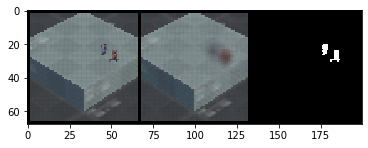

Storing weights 4314.897523828125 4314.932438671875
Epoch 32, loss 134.8405476196289
Storing weights 4314.85882890625 4314.897523828125
Epoch 33, loss 134.8393384033203
Storing weights 4314.82016015625 4314.85882890625
Epoch 34, loss 134.8381300048828
Epoch 35, loss 134.83815673828124
Storing weights 4314.761994921875 4314.82016015625
Epoch 36, loss 134.8363123413086


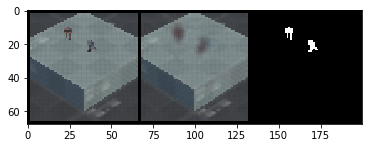

Storing weights 4314.740922265625 4314.761994921875
Epoch 37, loss 134.8356538208008
Storing weights 4314.716467578125 4314.740922265625
Epoch 38, loss 134.8348896118164
Storing weights 4314.67222890625 4314.716467578125
Epoch 39, loss 134.8335071533203
Storing weights 4314.657077734375 4314.67222890625
Epoch 40, loss 134.83303367919922
Storing weights 4314.642741796875 4314.657077734375
Epoch 41, loss 134.83258568115235


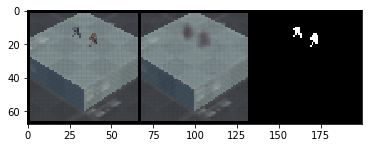

Storing weights 4314.62544765625 4314.642741796875
Epoch 42, loss 134.8320452392578
Storing weights 4314.589116796875 4314.62544765625
Epoch 43, loss 134.83090989990234
Epoch 44, loss 134.83116217041015
Storing weights 4314.5679796875 4314.589116796875
Epoch 45, loss 134.83024936523438
Storing weights 4314.543323828125 4314.5679796875
Epoch 46, loss 134.8294788696289


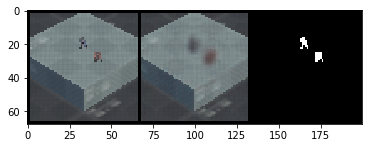

Storing weights 4314.5384046875 4314.543323828125
Epoch 47, loss 134.82932514648436
Storing weights 4314.515519140625 4314.5384046875
Epoch 48, loss 134.82860997314452
Storing weights 4314.48525703125 4314.515519140625
Epoch 49, loss 134.82766428222655
Storing weights 4314.4731921875 4314.48525703125
Epoch 50, loss 134.82728725585937
Storing weights 4314.450430859375 4314.4731921875
reducing lr
Epoch 51, loss 134.82657596435547


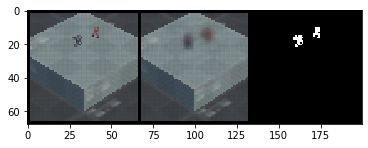

Storing weights 4314.0993859375 4314.450430859375
Epoch 52, loss 134.81560581054688
Storing weights 4314.053230078125 4314.0993859375
Epoch 53, loss 134.8141634399414
Storing weights 4314.04443359375 4314.053230078125
Epoch 54, loss 134.8138885498047
Storing weights 4314.031553125 4314.04443359375
Epoch 55, loss 134.81348603515625
Storing weights 4314.0288203125 4314.031553125
Epoch 56, loss 134.81340063476563


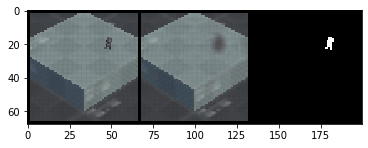

Storing weights 4314.01728671875 4314.0288203125
Epoch 57, loss 134.81304020996095
Storing weights 4314.01005703125 4314.01728671875
Epoch 58, loss 134.81281428222655
Storing weights 4314.007323828125 4314.01005703125
Epoch 59, loss 134.8127288696289
Storing weights 4314.0032109375 4314.007323828125
Epoch 60, loss 134.81260034179687
Storing weights 4313.995066015625 4314.0032109375
Epoch 61, loss 134.81234581298827


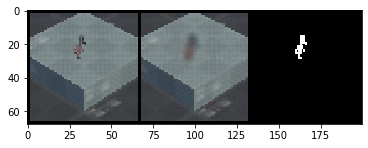

Storing weights 4313.994503515625 4313.995066015625
Epoch 62, loss 134.8123282348633
Storing weights 4313.989552734375 4313.994503515625
Epoch 63, loss 134.81217352294922
Storing weights 4313.98540546875 4313.989552734375
Epoch 64, loss 134.81204392089845
Storing weights 4313.984453515625 4313.98540546875
Epoch 65, loss 134.8120141723633
Storing weights 4313.97367265625 4313.984453515625
Epoch 66, loss 134.8116772705078


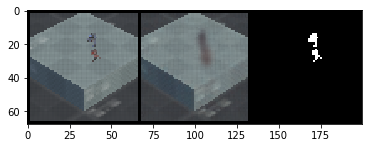

Epoch 67, loss 134.81170915527343
Storing weights 4313.968380859375 4313.97367265625
Epoch 68, loss 134.81151190185548
Epoch 69, loss 134.81151821289063
Storing weights 4313.9602234375 4313.968380859375
Epoch 70, loss 134.81125698242187
Epoch 71, loss 134.81130087890625


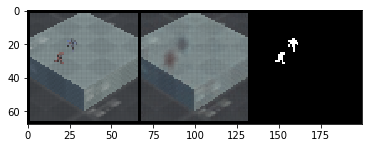

Storing weights 4313.95641015625 4313.9602234375
Epoch 72, loss 134.81113781738281
Storing weights 4313.952507421875 4313.95641015625
Epoch 73, loss 134.8110158569336
Epoch 74, loss 134.81101889648437
Storing weights 4313.951214453125 4313.952507421875
Epoch 75, loss 134.81097545166017
Storing weights 4313.946409375 4313.951214453125
Epoch 76, loss 134.81082529296876


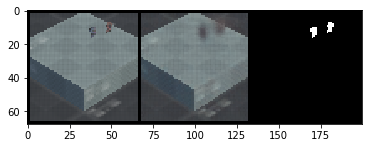

Storing weights 4313.945469921875 4313.946409375
Epoch 77, loss 134.8107959350586
Storing weights 4313.937198046875 4313.945469921875
Epoch 78, loss 134.81053743896484
Epoch 79, loss 134.81056580810548
Storing weights 4313.933801171875 4313.937198046875
Epoch 80, loss 134.81043128662108
Epoch 81, loss 134.81045346679687


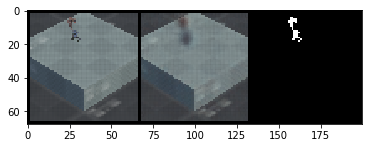

Storing weights 4313.931167578125 4313.933801171875
Epoch 82, loss 134.8103489868164
Storing weights 4313.92790078125 4313.931167578125
Epoch 83, loss 134.81024689941407
Epoch 84, loss 134.81025673828125
Storing weights 4313.924187890625 4313.92790078125
Epoch 85, loss 134.81013087158203
Storing weights 4313.922209765625 4313.924187890625
Epoch 86, loss 134.81006905517577


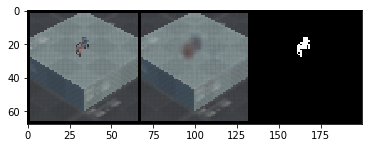

Storing weights 4313.9180515625 4313.922209765625
Epoch 87, loss 134.80993911132813
Storing weights 4313.91579453125 4313.9180515625
Epoch 88, loss 134.80986857910156
Storing weights 4313.912458203125 4313.91579453125
Epoch 89, loss 134.80976431884767
Epoch 90, loss 134.8098291503906
Storing weights 4313.912237890625 4313.912458203125
Epoch 91, loss 134.80975743408203


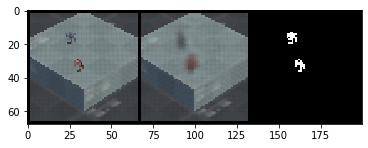

Storing weights 4313.90926171875 4313.912237890625
Epoch 92, loss 134.80966442871093
Storing weights 4313.90672109375 4313.90926171875
Epoch 93, loss 134.8095850341797
Storing weights 4313.902046875 4313.90672109375
Epoch 94, loss 134.80943896484376
Storing weights 4313.900016796875 4313.902046875
Epoch 95, loss 134.80937552490235
Storing weights 4313.89962578125 4313.900016796875
Epoch 96, loss 134.80936330566405


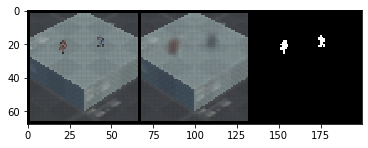

Storing weights 4313.895705859375 4313.89962578125
Epoch 97, loss 134.80924080810547
Storing weights 4313.894688671875 4313.895705859375
Epoch 98, loss 134.8092090209961
Storing weights 4313.894331640625 4313.894688671875
Epoch 99, loss 134.80919786376953
Storing weights 4313.892871484375 4313.894331640625
Epoch 100, loss 134.80915223388672
Storing weights 4313.88865390625 4313.892871484375
reducing lr
Epoch 101, loss 134.8090204345703


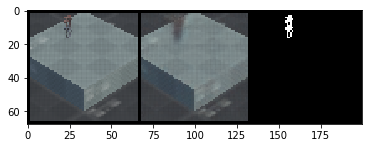

Storing weights 4313.8453328125 4313.88865390625
Epoch 102, loss 134.80766665039062
Storing weights 4313.843919140625 4313.8453328125
Epoch 103, loss 134.80762247314453
Storing weights 4313.83479453125 4313.843919140625
Epoch 104, loss 134.80733732910156
Epoch 105, loss 134.80740625
Epoch 106, loss 134.8074865234375


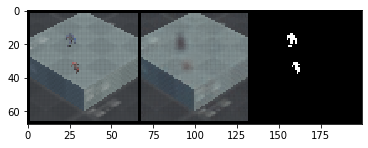

Epoch 107, loss 134.8074038330078
Epoch 108, loss 134.80743764648437
Epoch 109, loss 134.80739107666017
Storing weights 4313.83466171875 4313.83479453125
Epoch 110, loss 134.80733317871093
Storing weights 4313.834049609375 4313.83466171875
Epoch 111, loss 134.80731405029297


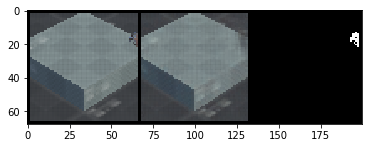

Epoch 112, loss 134.80733276367187
Epoch 113, loss 134.80735815429688
Epoch 114, loss 134.80731414794923
Epoch 115, loss 134.80731826171876
Storing weights 4313.832540625 4313.834049609375
Epoch 116, loss 134.80726689453124


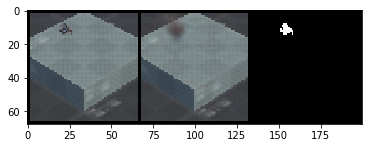

Epoch 117, loss 134.80730721435546
Storing weights 4313.832387890625 4313.832540625
Epoch 118, loss 134.80726212158203
Epoch 119, loss 134.8072655517578
Storing weights 4313.830483203125 4313.832387890625
Epoch 120, loss 134.80720260009767
Epoch 121, loss 134.8072524658203


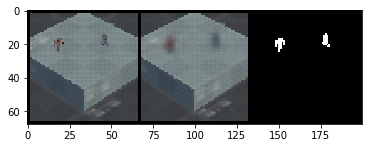

Epoch 122, loss 134.80728594970702
Epoch 123, loss 134.80730925292968
Epoch 124, loss 134.80737025146485
Epoch 125, loss 134.80732769775392
Epoch 126, loss 134.80725998535155


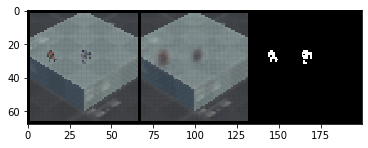

Epoch 127, loss 134.8072656982422
Storing weights 4313.830327734375 4313.830483203125
Epoch 128, loss 134.8071977416992
Storing weights 4313.83008046875 4313.830327734375
Epoch 129, loss 134.80719001464843
Storing weights 4313.82933984375 4313.83008046875
Epoch 130, loss 134.8071668701172
Epoch 131, loss 134.80725710449218


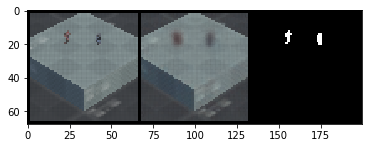

Epoch 132, loss 134.807203515625
Epoch 133, loss 134.8071887939453
Epoch 134, loss 134.80718397216796
Epoch 135, loss 134.80718963623048
Storing weights 4313.826437109375 4313.82933984375
Epoch 136, loss 134.80707615966796


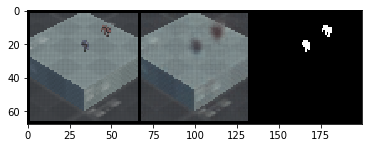

Epoch 137, loss 134.8071109741211
Epoch 138, loss 134.80736118164063
Epoch 139, loss 134.80722817382812
Storing weights 4313.824465234375 4313.826437109375
Epoch 140, loss 134.8070145385742
Epoch 141, loss 134.807122265625


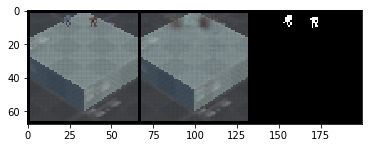

Epoch 142, loss 134.80706309814454
Epoch 143, loss 134.80708865966798
Epoch 144, loss 134.80709674072267
Epoch 145, loss 134.80707767333985
Epoch 146, loss 134.8070829223633


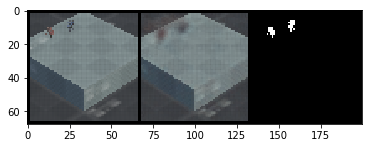

Epoch 147, loss 134.80706614990234
Storing weights 4313.82423046875 4313.824465234375
Epoch 148, loss 134.80700720214844
Epoch 149, loss 134.80705166015625
Storing weights 4313.8240953125 4313.82423046875
Epoch 150, loss 134.8070029785156


In [0]:
# https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb <-- source for code. 
def loss_fn(recon_x, x, vae_weights, mu, logvar, use_weights):
    # Generate weights

    # Weighted BCE
    # vae_weights = torch.ones(1, 3, 64, 64).to(device)
    # vae_weights[:,0,:,:] *= 0.001
    # vae_weights *= 0.99
    # vae_weights = vae_weights.repeat(recon_x.shape[0], 1, 1, 1)
    if use_weights:
        BCE = F.binary_cross_entropy(recon_x, x, weight=vae_weights, reduction='sum').div(batch_size)
    else:
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum').div(batch_size)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

def compare(x, f, vae):
    vae.eval()
    recon_x, _, _ = vae(x)
    vae.train()
    return torch.cat([x, recon_x, f])

def max_rgb_filter(image):
	(R, G, B) = cv2.split(image)
 
	# find the maximum pixel intensity values for each
	# (x, y)-coordinate,, then set all pixel values less
	# than M to zero
	M = np.maximum(np.maximum(R, G), B)
	R[R < M] = 0
	G[G < M] = 0
	B[B < M] = 0
 
	# merge the channels back together and return the image
	return cv2.merge([R, G, B])
 
def main(episodes):
    best_loss = 9999999
    epochs = 150
    for use_weights in [0, 1]:
        print('===========================')
        print('Training new model with weights: {}'.format(use_weights))
        print('===========================')
        vae = VAE(image_channels=3).to(device)
        optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
        vae.train()
        print('Loaded model.')
        for epoch in range(epochs):
            losses = [] 
            batch_loss = 0
            
            for i, batch in enumerate(dataloader):
                optimizer.zero_grad()

                f = batch[:,1,:,:,:].squeeze().to(device)
                f[f > 0] = 5
                f[f == 0] = 0.5

                b = batch[:,0,:,:,:].squeeze().to(device)
                recon_images, mu, logvar = vae(b)
                
                loss, bce, kld = loss_fn(recon_images, b, f, mu, logvar, use_weights)
                loss.backward()
                optimizer.step()
                batch_loss += loss.item()

            batch_loss /= len(dataloader)
            if batch_loss < best_loss:
                print('Storing weights', batch_loss, best_loss)
                best_loss = batch_loss
                torch.save(vae.state_dict(), '{}/neurosmash/vae_v3_weights_{}.torch'.format(base_url, use_weights))

            if epoch == 50:
                print('reducing lr')
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-4
            elif epoch == 100:
                print('reducing lr')
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-5
            
            print('Epoch {}, loss {}'.format(epoch+1, batch_loss / batch_size))

            if epoch % 5 == 0:
                # Store model. 
                idx = randint(0, len(b)-1)           
                fixed_x = b[idx].unsqueeze(0)
                fixed_filter = batch[:,1,:,:,:].squeeze()[idx].unsqueeze(0)
                compare_x = compare(fixed_x.to(device), fixed_filter.to(device), vae)
                
                # print(torch.stack(, compare_x).shape)
                save_image(compare_x.data.cpu(), '{}/img_vae_{}/sample_image_epoch_{}.png'.format(base_url, use_weights, epoch))

                # Show final result. 
                img = mpimg.imread('{}/img_vae_{}/sample_image_epoch_{}.png'.format(base_url, use_weights, epoch))
                imgplot = plt.imshow(img.squeeze())
                plt.show()
main(50)

Encoding training data.
Weights 0
Trainable parameters encoder:  231200
Trainable parameters decoder:  43931
torch.Size([2000, 20, 32])


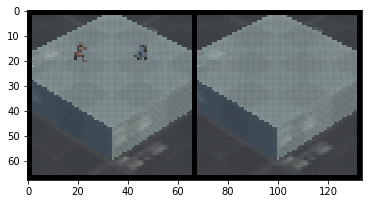

Weights 1
Trainable parameters encoder:  231200
Trainable parameters decoder:  43931
torch.Size([2000, 20, 32])


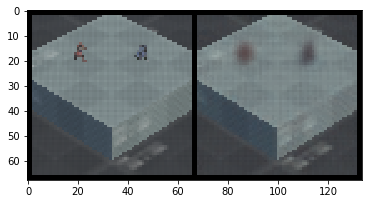

In [34]:
def compare(x, vae):
    recon_x, _, _ = vae(x)
    return torch.cat([x, recon_x])

#TODO: Load model.
import numpy as np
print('Encoding training data.')
#TODO Store all processed dps.
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
device = torch.device('cpu')
for use_weights in [0, 1]:
    print('Weights', use_weights)
    res = []
    vae = VAE(image_channels=3).to(device)
    vae.load_state_dict(torch.load('{}/neurosmash/vae_v3_weights_{}.torch'.format(base_url, use_weights), map_location='cpu'))
    vae.eval()
    for batch in dataloader:
        batch = batch.squeeze(0)
        batch = batch.to(device)
        z, mu, logvar = vae.encode(batch)
        res.append(z)
    res = torch.stack(res)
    torch.save(res, '{}/neurosmash/training_data_encoded_weighted_loss_{}.pt'.format(base_url, use_weights))
    print(res.shape)
    # Print image to make sure we have the right set.
    fixed_x = batch[0].unsqueeze(0)
    compare_x = compare(fixed_x.to(device), vae)
    save_image(compare_x.data.cpu(), '{}/sample_image_{}.png'.format(base_url, use_weights))

    # Show final result. 
    img = mpimg.imread('{}/sample_image_{}.png'.format(base_url, use_weights))
    imgplot = plt.imshow(img.squeeze())
    plt.show()

## Beta VAE

In [0]:
"""model.py"""

import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable


def reparametrize(mu, logvar):
    std = logvar.div(2).exp()
    eps = Variable(std.data.new(std.size()).normal_())
    return mu + std*eps


class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)


class BetaVAE_H(nn.Module):
    """Model proposed in original beta-VAE paper(Higgins et al, ICLR, 2017)."""

    def __init__(self, z_dim=10, nc=3):
        super(BetaVAE_H, self).__init__()
        self.z_dim = z_dim
        self.nc = nc
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 32, 4, 2, 1),          # B,  32, 32, 32
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32, 16, 16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),          # B,  64,  8,  8
            nn.ReLU(True),
            nn.Conv2d(64, 64, 4, 2, 1),          # B,  64,  4,  4
            nn.ReLU(True),
            nn.Conv2d(64, 256, 4, 1),            # B, 256,  1,  1
            nn.ReLU(True),
            View((-1, 256*1*1)),                 # B, 256
            nn.Linear(256, z_dim*2),             # B, z_dim*2
        )

        model_parameters = filter(lambda p: p.requires_grad, self.encoder.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print('Trainable parameters encoder: ', params)
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 64),               # B, 256
            View((-1, 64, 1, 1)),               # B, 256,  1,  1
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4),      # B,  64,  4,  4
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1), # B,  64,  8,  8
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, 2, 1), # B,  32, 16, 16
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 8, 4, 2, 1), # B,  32, 32, 32
            nn.ReLU(True),
            nn.ConvTranspose2d(8, nc, 4, 2, 1),  # B, nc, 64, 64
        )

        model_parameters = filter(lambda p: p.requires_grad, self.decoder.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print('Trainable parameters encoder: ', params)

        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        distributions = self._encode(x)
        mu = distributions[:, :self.z_dim]
        logvar = distributions[:, self.z_dim:]
        z = reparametrize(mu, logvar)
        x_recon = self._decode(z)

        return x_recon, mu, logvar

    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)


def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)


def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim import Adam
from PIL import Image
import torch.nn.functional as F
import numpy as np
import torch
from torch.autograd import Variable
from torch.distributions import Categorical
from random import randint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, transform
import cv2

%matplotlib inline

from torchvision.utils import save_image
device = torch.device('cuda')

batch_size = 64

objective = 'H'
beta = 2
lr =  1e-4
z_dim =  32
max_iter =  1.5e6
decoder_dist = 'gaussian'

vae = BetaVAE_H(nc=3, z_dim=z_dim)
vae = vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr, betas=(0.9, 0.999))
print('Loaded model.')

# https://github.com/1Konny/Beta-VAE/blob/master/solver.py 

def mse_loss(input, target):
    return torch.sum((input - target) ** 2)

def weighted_mse_loss(input, target, weight):
    return torch.sum(weight * (input - target) ** 2)

def reconstruction_loss(x, x_recon, weights, distribution):
    batch_size = x.size(0)
    assert batch_size != 0

    if distribution == 'bernoulli':
        recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, size_average=False).div(batch_size)
    elif distribution == 'gaussian':
        # x_recon = F.sigmoid(x_recon)
        recon_loss = weighted_mse_loss(x_recon, x, weight=weights).sum() #F.mse_loss(x_recon, x, weights=weights, reduction='sum').div(batch_size)#, size_average=False).div(batch_size)
    else:
        recon_loss = None

    return recon_loss


def kl_divergence(mu, logvar):
    batch_size = mu.size(0)
    assert batch_size != 0
    if mu.data.ndimension() == 4:
        mu = mu.view(mu.size(0), mu.size(1))
    if logvar.data.ndimension() == 4:
        logvar = logvar.view(logvar.size(0), logvar.size(1))

    klds = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())
    total_kld = klds.sum(1).mean(0, True)
    dimension_wise_kld = klds.mean(0)
    mean_kld = klds.mean(1).mean(0, True)

    return total_kld, dimension_wise_kld, mean_kld


def compare(x):
    recon_x, _, _ = vae(x)
    return torch.cat([x, recon_x])

def max_rgb_filter(image):
	# split the image into its BGR components
	(R, G, B) = cv2.split(image)
 
	# find the maximum pixel intensity values for each
	# (x, y)-coordinate,, then set all pixel values less
	# than M to zero
	M = np.maximum(np.maximum(R, G), B)
	R[R < M] = 0
	G[G < M] = 0
	B[B < M] = 0
 
	# merge the channels back together and return the image
	return cv2.merge([R, G, B])
def main(episodes):
    dataset = None
    for i in range(1):
        if dataset is None:
            dataset = torch.load('{}/data/training_data_{}.pt'.format(base_url, i)) / 255
        else:
            dataset = torch.cat((dataset, torch.load('{}/data/training_data_{}.pt'.format(base_url, i)) / 255))
    
    test_dataset = torch.load('{}/data/training_data_{}.pt'.format(base_url, i+1)) / 255
    dataset = np.array([np.transpose(x.data.numpy(), (1,2,0)) for x in dataset])  

    if mode == 'ext':
        dataset = [max_rgb_filter(np.uint8(x*255)) for x in dataset]
        dataset = np.transpose(dataset, (0, 3, 1, 2))
        dataset[:,0,:,:] *= 0
    elif mode == 'canny':
        filters = [cv2.Canny(np.uint8(x_*255*255), 100, 200) for x_ in dataset]
        dataset = np.array([cv2.bitwise_and(x_, x_, mask=f) for x_, f in zip(dataset, filters)])
        dataset = np.transpose(dataset, (0, 3, 1, 2))
    elif mode == 'filter':
        filters = np.repeat(np.array([np.array(cv2.Canny(np.uint8(x_*255*255), 100, 200)) for x_ in dataset]).reshape(-1, 1, 64, 64), 3, axis=1)
        dataset = np.transpose(dataset, (0, 3, 1, 2))
        dataset = np.array([np.array([x, f]) for x,f in zip(dataset, filters)])

    dataset = torch.from_numpy(dataset).float() #/ 255

    # dataset = dataset[:100]
    # # Divide by 255
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    epochs = 125
    print(dataset.shape, test_dataset.shape)
    for epoch in range(epochs):
        losses = [] 
        for i, batch in enumerate(dataloader):
            optimizer.zero_grad()

            f = (batch[:,1,:,:,:].squeeze()).to(device)
            f[f == 0] = 0.05
            f[f == 255] = 10

            b = batch[:,0,:,:,:].squeeze().to(device)

            x_recon, mu, logvar = vae(b)
            recon_loss = reconstruction_loss(b, x_recon, f, decoder_dist)
            total_kld, dim_wise_kld, mean_kld = kl_divergence(mu, logvar)

            loss = recon_loss + beta*total_kld
            # elif objective == 'B':
            #     C = torch.clamp(self.C_max/self.C_stop_iter*self.global_iter, 0, self.C_max.data[0])
            #     beta_vae_loss = recon_loss + self.gamma*(total_kld-C).abs()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch == 100:
            print('reducing lr')
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-4
        print('Epoch {}, loss {}'.format(epoch+1, loss.item() / batch_size))
        if epoch % 5 == 0:
            fixed_x = b[randint(0, len(b)-1)].unsqueeze(0)
            compare_x = compare(fixed_x.to(device))
            
            # print(torch.stack(, compare_x).shape)
            save_image(compare_x.data.cpu(), '{}/neurosmash/images/sample_image_epoch_{}.png'.format(base_url, epoch))

            # Show final result. 
            img = mpimg.imread('{}/neurosmash/images/sample_image_epoch_{}.png'.format(base_url, epoch))
            imgplot = plt.imshow(img.squeeze())
            plt.show()
    
    print('Predicting test set:')
    for i, batch in enumerate(test_dataloader):
        if i > 10:
            break
        b = b.to(device)
        recon_images, mu, logvar = vae(b)

        fixed_x = b[randint(0, len(b)-1)].unsqueeze(0)
        compare_x = compare(fixed_x.to(device))
        
        save_image(compare_x.data.cpu(), '{}/neurosmash/images/sample_image_test_epoch_{}.png'.format(base_url, epoch))

        # Show final result. 
        img = mpimg.imread('{}/neurosmash/images/sample_image_test_epoch_{}.png'.format(base_url, epoch))
        imgplot = plt.imshow(img.squeeze())
        plt.show()

    # Store model. 
    torch.save(vae.state_dict(), 'b_vae.torch')
main(50)

## InfoVAE

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Conv2d(3, 64, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            Flatten(),
            torch.nn.Linear(32768, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, z_dim)
        ])
        
    def forward(self, x):
        #print("Encoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x
    
    
class Decoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Linear(z_dim, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 32768),
            torch.nn.ReLU(),
            Reshape((128,16,16,)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 3, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ])
        
    def forward(self, x):
        #print("Decoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x

def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

class Model(torch.nn.Module):
    def __init__(self, z_dim):
        super(Model, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import math
import matplotlib.pyplot as plt


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

%matplotlib inline
z_dim = 4
vae = Model(z_dim).to(device)#VAE(image_channels=3).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
print('Loaded model.')

# https://github.com/napsternxg/pytorch-practice/blob/master/Pytorch%20-%20MMD%20VAE.ipynb
def compare(x):
    _, recon_x = vae(x)
    return torch.cat([x, recon_x])


def main(episodes):
    dataset = torch.load('{}/data/training_data_0.pt'.format(base_url)) #/ 255

    # Grayscale convertion.
    # dataset = [to_pil_image(x_) for x_ in dataset]
    # dataset = [to_grayscale(x_, 1) for x_ in dataset]
    # dataset = torch.stack([to_tensor(x_) for x_ in dataset])

    dataset = np.array([np.transpose(x.data.numpy(), (1,2,0)) for x in dataset])

    filters = [cv2.Canny(np.uint8(x_*255), 100, 200) for x_ in dataset]
    dataset = np.array([cv2.bitwise_and(x_, x_, mask=f) for x_, f in zip(dataset, filters)])
    dataset = np.transpose(dataset, (0, 3, 1, 2))


    # Divide by 255
    dataset = torch.from_numpy(dataset) / 255
    dataloader = torch.utils.data.DataLoader(dataset[:100], batch_size=batch_size, shuffle=True)
    epochs = 10000
    for epoch in range(epochs):
        losses = [] 
        for i, b in enumerate(dataloader):
            optimizer.zero_grad()
            x = b.to(device)
            z, x_reconstructed = vae(x) 

            true_samples = torch.randn(200, z_dim, requires_grad=False).to(device)
            mmd = compute_mmd(true_samples, z)
            nll = (x_reconstructed - x).pow(2).sum()
            loss = nll + mmd*2
            loss.backward()
            optimizer.step()
        if (epoch % 500 == 0) or (epoch == epochs-1):
            # Store one image per epoch to showcase development of VAE.
            print('Epoch {} loss {}'.format(epoch, loss.item()))
            fixed_x = dataset[1].unsqueeze(0)
            compare_x = compare(fixed_x.to(device))
            save_image(compare_x.data.cpu(), '{}/neurosmash/images_infovae/sample_image_epoch_{}.png'.format(base_url, epoch+1))

        print('Epoch {}, loss {}'.format(epoch+1, loss.item()))
    # Store model. 
    torch.save(vae.state_dict(), '{}/vae.torch'.format(base_url))

    # Show final result. 
    img = mpimg.imread('{}/neurosmash/images_infovae/sample_image_epoch_{}.png'.format(base_url, epochs))
    imgplot = plt.imshow(img)
    plt.show()

main(50)

## VAE-GAN <-- wtf is even happening here..

In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy
from torchvision.utils import save_image
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim import Adam
from PIL import Image
import torch.nn.functional as F
import numpy as np
import torch
from torch.autograd import Variable
from torch.distributions import Categorical
from random import randint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, transform


# encoder block (used in encoder and discriminator)
class EncoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(EncoderBlock, self).__init__()
        # convolution to halve the dimensions
        self.conv = nn.Conv2d(in_channels=channel_in, out_channels=channel_out, kernel_size=5, padding=2, stride=2,
                              bias=False)
        self.bn = nn.BatchNorm2d(num_features=channel_out, momentum=0.9)

    def forward(self, ten, out=False,t = False):
        # here we want to be able to take an intermediate output for reconstruction error
        if out:
            ten = self.conv(ten)
            ten_out = ten
            ten = self.bn(ten)
            ten = F.relu(ten, False)
            return ten, ten_out
        else:
            ten = self.conv(ten)
            ten = self.bn(ten)
            ten = F.relu(ten, True)
            return ten


# decoder block (used in the decoder)
class DecoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(DecoderBlock, self).__init__()
        # transpose convolution to double the dimensions
        self.conv = nn.ConvTranspose2d(channel_in, channel_out, kernel_size=5, padding=2, stride=2, output_padding=1,
                                       bias=False)
        self.bn = nn.BatchNorm2d(channel_out, momentum=0.9)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = self.bn(ten)
        ten = F.relu(ten, True)
        return ten


class Encoder(nn.Module):
    def __init__(self, channel_in=3, z_size=128):
        super(Encoder, self).__init__()
        self.size = channel_in
        layers_list = []
        # the first time 3->64, for every other double the channel size
        for i in range(3):
            if i == 0:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=64))
                self.size = 64
            else:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=self.size * 2))
                self.size *= 2

        # final shape Bx256x8x8
        self.conv = nn.Sequential(*layers_list)
        self.fc = nn.Sequential(nn.Linear(in_features=8 * 8 * self.size, out_features=1024, bias=False),
                                nn.BatchNorm1d(num_features=1024,momentum=0.9),
                                nn.ReLU(True))
        # two linear to get the mu vector and the diagonal of the log_variance
        self.l_mu = nn.Linear(in_features=1024, out_features=z_size)
        self.l_var = nn.Linear(in_features=1024, out_features=z_size)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = ten.view(len(ten), -1)
        ten = self.fc(ten)
        mu = self.l_mu(ten)
        logvar = self.l_var(ten)
        return mu, logvar

    def __call__(self, *args, **kwargs):
        return super(Encoder, self).__call__(*args, **kwargs)


class Decoder(nn.Module):
    def __init__(self, z_size, size):
        super(Decoder, self).__init__()
        # start from B*z_size
        self.fc = nn.Sequential(nn.Linear(in_features=z_size, out_features=8 * 8 * size, bias=False),
                                nn.BatchNorm1d(num_features=8 * 8 * size,momentum=0.9),
                                nn.ReLU(True))
        self.size = size
        layers_list = []
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size))
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        self.size = self.size//2
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//4))
        self.size = self.size//4
        # final conv to get 3 channels and tanh layer
        layers_list.append(nn.Sequential(
            nn.Conv2d(in_channels=self.size, out_channels=3, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        ))

        self.conv = nn.Sequential(*layers_list)

    def forward(self, ten):

        ten = self.fc(ten)
        ten = ten.view(len(ten), -1, 8, 8)
        ten = self.conv(ten)
        return ten

    def __call__(self, *args, **kwargs):
        return super(Decoder, self).__call__(*args, **kwargs)


class Discriminator(nn.Module):
    def __init__(self, channel_in=3,recon_level=3):
        super(Discriminator, self).__init__()
        self.size = channel_in
        self.recon_levl = recon_level
        # module list because we need need to extract an intermediate output
        self.conv = nn.ModuleList()
        self.conv.append(nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True)))
        self.size = 32
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=128))
        self.size = 128
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=256))
        self.size = 256
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=256))
        # final fc to get the score (real or fake)
        self.fc = nn.Sequential(
            nn.Linear(in_features=8 * 8 * self.size, out_features=512, bias=False),
            nn.BatchNorm1d(num_features=512,momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=1),

        )

    def forward(self, ten,other_ten,mode='REC'):
        if mode == "REC":
            ten = torch.cat((ten, other_ten), 0)
            for i, lay in enumerate(self.conv):
                # we take the 9th layer as one of the outputs
                if i == self.recon_levl:
                    ten, layer_ten = lay(ten, True)
                    # we need the layer representations just for the original and reconstructed,
                    # flatten, because it's a convolutional shape
                    layer_ten = layer_ten.view(len(layer_ten), -1)
                    return layer_ten
                else:
                    ten = lay(ten)
        else:
            ten = torch.cat((ten, other_ten), 0)
            for i, lay in enumerate(self.conv):
                    ten = lay(ten)

            ten = ten.view(len(ten), -1)
            ten = self.fc(ten)
            return F.sigmoid(ten)


    def __call__(self, *args, **kwargs):
        return super(Discriminator, self).__call__(*args, **kwargs)


class VaeGan(nn.Module):
    def __init__(self,z_size=128,recon_level=3):
        super(VaeGan, self).__init__()
        # latent space size
        self.z_size = z_size
        self.encoder = Encoder(z_size=self.z_size)
        self.decoder = Decoder(z_size=self.z_size, size=self.encoder.size)
        self.discriminator = Discriminator(channel_in=3,recon_level=recon_level)
        # self-defined function to init the parameters
        self.init_parameters()

    def init_parameters(self):
        # just explore the network, find every weight and bias matrix and fill it
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                if hasattr(m, "weight") and m.weight is not None and m.weight.requires_grad:
                    #init as original implementation
                    scale = 1.0/numpy.sqrt(numpy.prod(m.weight.shape[1:]))
                    scale /=numpy.sqrt(3)
                    #nn.init.xavier_normal(m.weight,1)
                    #nn.init.constant(m.weight,0.005)
                    nn.init.uniform(m.weight,-scale,scale)
                if hasattr(m, "bias") and m.bias is not None and m.bias.requires_grad:
                    nn.init.constant(m.bias, 0.0)

    def forward(self, ten, gen_size=10):
        if self.training:
            # save the original images
            ten_original = ten
            # encode
            mus, log_variances = self.encoder(ten)
            # we need the true variances, not the log one
            variances = torch.exp(log_variances * 0.5)
            # sample from a gaussian

            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            # shift and scale using the means and variances

            ten = ten_from_normal * variances + mus
            # decode the tensor
            ten = self.decoder(ten)
            # discriminator for reconstruction
            ten_layer = self.discriminator(ten, ten_original, "REC")
            # decoder for samples

            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)

            ten = self.decoder(ten_from_normal)
            ten_class = self.discriminator(ten_original, ten, "GAN")
            return ten, ten_class, ten_layer, mus, log_variances
        else:
            if ten is None:
                # just sample and decode

                ten = Variable(torch.randn(gen_size, self.z_size).cuda(), requires_grad=False)
                ten = self.decoder(ten)
            else:
                mus, log_variances = self.encoder(ten)
                # we need the true variances, not the log one
                variances = torch.exp(log_variances * 0.5)
                # sample from a gaussian

                ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=False)
                # shift and scale using the means and variances
                ten = ten_from_normal * variances + mus
                # decode the tensor
                ten = self.decoder(ten)
            return ten



    def __call__(self, *args, **kwargs):
        return super(VaeGan, self).__call__(*args, **kwargs)

    @staticmethod
    def loss(ten_original, ten_predict, layer_original, layer_predicted, labels_original,
             labels_sampled, mus, variances):
        """
        :param ten_original: original images
        :param ten_predict:  predicted images (output of the decoder)
        :param layer_original:  intermediate layer for original (intermediate output of the discriminator)
        :param layer_predicted: intermediate layer for reconstructed (intermediate output of the discriminator)
        :param labels_original: labels for original (output of the discriminator)
        :param labels_predicted: labels for reconstructed (output of the discriminator)
        :param labels_sampled: labels for sampled from gaussian (0,1) (output of the discriminator)
        :param mus: tensor of means
        :param variances: tensor of diagonals of log_variances
        :return:
        """

        # reconstruction error, not used for the loss but useful to evaluate quality
        nle = 0.5*(ten_original.view(len(ten_original), -1) - ten_predict.view(len(ten_predict), -1)) ** 2
        # kl-divergence
        kl = -0.5 * torch.sum(-variances.exp() - torch.pow(mus,2) + variances + 1, 1)
        # mse between intermediate layers
        mse = torch.sum(0.5*(layer_original - layer_predicted) ** 2, 1)
        # bce for decoder and discriminator for original,sampled and reconstructed
        # the only excluded is the bce_gen_original

        bce_dis_original = -torch.log(labels_original + 1e-3)
        bce_dis_sampled = -torch.log(1 - labels_sampled + 1e-3)

        bce_gen_original = -torch.log(1-labels_original + 1e-3)
        bce_gen_sampled = -torch.log(labels_sampled + 1e-3)
        '''
        
        bce_gen_predicted = nn.BCEWithLogitsLoss(size_average=False)(labels_predicted,
                                         Variable(torch.ones_like(labels_predicted.data).cuda(), requires_grad=False))
        bce_gen_sampled = nn.BCEWithLogitsLoss(size_average=False)(labels_sampled,
                                       Variable(torch.ones_like(labels_sampled.data).cuda(), requires_grad=False))
        bce_dis_original = nn.BCEWithLogitsLoss(size_average=False)(labels_original,
                                        Variable(torch.ones_like(labels_original.data).cuda(), requires_grad=False))
        bce_dis_predicted = nn.BCEWithLogitsLoss(size_average=False)(labels_predicted,
                                         Variable(torch.zeros_like(labels_predicted.data).cuda(), requires_grad=False))
        bce_dis_sampled = nn.BCEWithLogitsLoss(size_average=False)(labels_sampled,
                                       Variable(torch.zeros_like(labels_sampled.data).cuda(), requires_grad=False))
        '''
        return nle, kl, mse, bce_dis_original, bce_dis_sampled,bce_gen_original,bce_gen_sampled

In [0]:
# just a class to store a rolling average
# useful to log to TB
class RollingMeasure(object):
    def __init__(self):
        self.measure = 0.0
        self.iter = 0

    def __call__(self, measure):
        # passo nuovo valore e ottengo average
        # se first call inizializzo
        if self.iter == 0:
            self.measure = measure
        else:
            self.measure = (1.0 / self.iter * measure) + (1 - 1.0 / self.iter) * self.measure
        self.iter += 1
        return self.measure

In [0]:
!pip install tensorboardX

In [0]:
import torch
import numpy
numpy.random.seed(8)
torch.manual_seed(8)
torch.cuda.manual_seed(8)
from torch.autograd import Variable
from torch.utils.data import Dataset
from tensorboardX import SummaryWriter
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR,MultiStepLR
import progressbar
from torchvision.utils import make_grid


if __name__ == "__main__":

    train_folder = '{}/data/training_data_0.pt'.format(base_url)
    test_folder = '{}/data/training_data_1.pt'.format(base_url)
    z_size = 128#args.z_size
    recon_level = 3#args.recon_level
    decay_mse = 1#args.decay_mse
    decay_margin = 1#args.decay_margin
    n_epochs = 12#args.n_epochs
    lambda_mse = 1e-6#args.lambda_mse
    lr = 3e-4#args.lr
    decay_lr = 0.75#args.decay_lr
    decay_equilibrium = 1#args.decay_equilibrium
    slurm = False #args.slurm

    writer = SummaryWriter(comment="_CELEBA_NEW_DATA_STOCK_GAN")
    net = VaeGan(z_size=z_size,recon_level=recon_level).cuda()

    # train = torch.load(train_folder)

    # DATASET
    train = torch.load(train_folder)[:100]
    test = torch.load(test_folder)[:10]
    dataloader = torch.utils.data.DataLoader(train, batch_size=64,
                                                shuffle=True, num_workers=4)
    # DATASET for test
    # if you want to split train from test just move some files in another dir
    dataloader_test = torch.utils.data.DataLoader(test, batch_size=100,
                                                      shuffle=False, num_workers=1)

    #margin and equilibirum
    margin = 0.35
    equilibrium = 0.68
    #mse_lambda = 1.0
    # OPTIM-LOSS
    # an optimizer for each of the sub-networks, so we can selectively backprop
    #optimizer_encoder = Adam(params=net.encoder.parameters(),lr = lr,betas=(0.9,0.999))
    optimizer_encoder = RMSprop(params=net.encoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
    #lr_encoder = MultiStepLR(optimizer_encoder,milestones=[2],gamma=1)
    lr_encoder = ExponentialLR(optimizer_encoder, gamma=decay_lr)
    #optimizer_decoder = Adam(params=net.decoder.parameters(),lr = lr,betas=(0.9,0.999))
    optimizer_decoder = RMSprop(params=net.decoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
    lr_decoder = ExponentialLR(optimizer_decoder, gamma=decay_lr)
    #lr_decoder = MultiStepLR(optimizer_decoder,milestones=[2],gamma=1)
    #optimizer_discriminator = Adam(params=net.discriminator.parameters(),lr = lr,betas=(0.9,0.999))
    optimizer_discriminator = RMSprop(params=net.discriminator.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
    lr_discriminator = ExponentialLR(optimizer_discriminator, gamma=decay_lr)
    #lr_discriminator = MultiStepLR(optimizer_discriminator,milestones=[2],gamma=1)

    batch_number = len(dataloader)
    step_index = 0
    widgets = [

        'Batch: ', progressbar.Counter(),
        '/', progressbar.FormatCustomText('%(total)s', {"total": batch_number}),
        ' ', progressbar.Bar(marker="-", left='[', right=']'),
        ' ', progressbar.ETA(),
        ' ',
        progressbar.DynamicMessage('loss_nle'),
        ' ',
        progressbar.DynamicMessage('loss_encoder'),
        ' ',
        progressbar.DynamicMessage('loss_decoder'),
        ' ',
        progressbar.DynamicMessage('loss_discriminator'),
        ' ',
        progressbar.DynamicMessage('loss_mse_layer'),
        ' ',
        progressbar.DynamicMessage('loss_kld'),
        ' ',
        progressbar.DynamicMessage("epoch")
    ]
    # for each epoch
    if slurm:
        print(args)
    for i in range(n_epochs):
        print(i)

        progress = progressbar.ProgressBar(min_value=0, max_value=batch_number, initial_value=0,
                                           widgets=widgets).start()
        # reset rolling average
        loss_nle_mean = RollingMeasure()
        loss_encoder_mean = RollingMeasure()
        loss_decoder_mean = RollingMeasure()
        loss_discriminator_mean = RollingMeasure()
        loss_reconstruction_layer_mean = RollingMeasure()
        loss_kld_mean = RollingMeasure()
        gan_gen_eq_mean = RollingMeasure()
        gan_dis_eq_mean = RollingMeasure()
        print("LR:{}".format(lr_encoder.get_lr()))

        # for each batch
        for j, data_batch in enumerate(dataloader):
            data_batch = data_batch / 255
            target_batch = data_batch
            
            # set to train mode
            net.train()
            # target and input are the same images

            data_target = Variable(target_batch, requires_grad=False).float().cuda()
            data_in = Variable(data_batch, requires_grad=False).float().cuda()


            # get output
            out, out_labels, out_layer, mus, variances = net(data_in)
            # split so we can get the different parts
            out_layer_predicted = out_layer[:len(out_layer) // 2]
            out_layer_original = out_layer[len(out_layer) // 2:]
            # TODO set a batch_len variable to get a clean code here
            out_labels_original = out_labels[:len(out_labels) // 2]
            out_labels_sampled = out_labels[-len(out_labels) // 2:]
            # loss, nothing special here
            nle_value, kl_value, mse_value, bce_dis_original_value, bce_dis_sampled_value,\
                bce_gen_original_value,bce_gen_sampled_value= VaeGan.loss(data_target, out, out_layer_original,
                                                                         out_layer_predicted, out_labels_original,
                                                                          out_labels_sampled, mus,
                                                                         variances)
            # THIS IS THE MOST IMPORTANT PART OF THE CODE
            loss_encoder = torch.sum(kl_value)+torch.sum(mse_value)
            loss_discriminator = torch.sum(bce_dis_original_value) + torch.sum(bce_dis_sampled_value)
            loss_decoder = torch.sum(lambda_mse * mse_value) - (1.0 - lambda_mse) * loss_discriminator
            # register mean values of the losses for logging
            loss_nle_mean(torch.mean(nle_value).data.cpu().numpy())
            loss_discriminator_mean((torch.mean(bce_dis_original_value) + torch.mean(bce_dis_sampled_value)).data.cpu().numpy())
            loss_decoder_mean((torch.mean(lambda_mse * mse_value) - (1 - lambda_mse) * (torch.mean(bce_dis_original_value) + torch.mean(bce_dis_sampled_value))).data.cpu().numpy())

            loss_encoder_mean((torch.mean(kl_value) + torch.mean(mse_value)).data.cpu().numpy())
            loss_reconstruction_layer_mean(torch.mean(mse_value).data.cpu().numpy())
            loss_kld_mean(torch.mean(kl_value).data.cpu().numpy())
            # selectively disable the decoder of the discriminator if they are unbalanced
            train_dis = True
            train_dec = True
            if torch.mean(bce_dis_original_value).item() < equilibrium-margin or torch.mean(bce_dis_sampled_value).item() < equilibrium-margin:
                train_dis = False
            if torch.mean(bce_dis_original_value).item() > equilibrium+margin or torch.mean(bce_dis_sampled_value).item() > equilibrium+margin:
                train_dec = False
            if train_dec is False and train_dis is False:
                train_dis = True
                train_dec = True

            #aggiungo log
            if train_dis:
                gan_dis_eq_mean(1.0)
            else:
                gan_dis_eq_mean(0.0)

            if train_dec:
                gan_gen_eq_mean(1.0)
            else:
                gan_gen_eq_mean(0.0)

            # BACKPROP
            # clean grads
            net.zero_grad()
            # encoder
            loss_encoder.backward(retain_graph=True)
            # someone likes to clamp the grad here
            #[p.grad.data.clamp_(-1,1) for p in net.encoder.parameters()]
            # update parameters
            optimizer_encoder.step()
            # clean others, so they are not afflicted by encoder loss
            net.zero_grad()
            #decoder
            if train_dec:
                loss_decoder.backward(retain_graph=True)
                #[p.grad.data.clamp_(-1,1) for p in net.decoder.parameters()]
                optimizer_decoder.step()
                #clean the discriminator
                net.discriminator.zero_grad()
            #discriminator
            if train_dis:
                loss_discriminator.backward()
                #[p.grad.data.clamp_(-1,1) for p in net.discriminator.parameters()]
                optimizer_discriminator.step()

            # LOGGING
            # if  slurm:
            # progress.update(progress.value + 1, loss_nle=loss_nle_mean.measure,
            #                 loss_encoder=loss_encoder_mean.measure,
            #                 loss_decoder=loss_decoder_mean.measure,
            #                 loss_discriminator=loss_discriminator_mean.measure,
            #                 loss_mse_layer=loss_reconstruction_layer_mean.measure,
            #                 loss_kld=loss_kld_mean.measure,
            #                 epoch=i + 1)

        # EPOCH END
        progress.update(progress.value + 1, loss_nle=loss_nle_mean.measure,
                        loss_encoder=loss_encoder_mean.measure,
                        loss_decoder=loss_decoder_mean.measure,
                        loss_discriminator=loss_discriminator_mean.measure,
                        loss_mse_layer=loss_reconstruction_layer_mean.measure,
                        loss_kld=loss_kld_mean.measure,
                        epoch=i + 1)
        lr_encoder.step()
        lr_decoder.step()
        lr_discriminator.step()
        margin *=decay_margin
        equilibrium *=decay_equilibrium
        #margin non puo essere piu alto di equilibrium
        if margin > equilibrium:
            equilibrium = margin
        lambda_mse *=decay_mse
        if lambda_mse > 1:
            lambda_mse=1
        progress.finish()

        writer.add_scalar('loss_encoder', loss_encoder_mean.measure, step_index)
        writer.add_scalar('loss_decoder', loss_decoder_mean.measure, step_index)
        writer.add_scalar('loss_discriminator', loss_discriminator_mean.measure, step_index)
        writer.add_scalar('loss_reconstruction', loss_nle_mean.measure, step_index)
        writer.add_scalar('loss_kld',loss_kld_mean.measure,step_index)
        writer.add_scalar('gan_gen',gan_gen_eq_mean.measure,step_index)
        writer.add_scalar('gan_dis',gan_dis_eq_mean.measure,step_index)

    for j, data_batch in enumerate(dataloader_test):
        data_batch = data_batch / 255
        target_batch = data_batch
        net.eval()

        data_in = Variable(data_batch, requires_grad=False).float().cuda()
        data_target = Variable(target_batch, requires_grad=False).float().cuda()
        out = net(data_in)
        out = out.data.cpu()
        out = (out + 1) / 2
        out = make_grid(out, nrow=8)
        save_image(out.data.cpu(), '{}/neurosmash/images_gan/sample_image_epoch_{}_rec.png'.format(base_url, j))

        img = mpimg.imread('{}/neurosmash/images_gan/sample_image_epoch_{}_rec.png'.format(base_url, j))
        imgplot = plt.imshow(img)
        plt.show()
        # out = net(None, 100)
        # out = out.data.cpu()
        # out = (out + 1) / 2
        # out = make_grid(out, nrow=8)
        # writer.add_image("generated", out, step_index)

        out = data_target.data.cpu()
        out = (out + 1) / 2
        out = make_grid(out, nrow=8)
        save_image(out.data.cpu(), '{}/neurosmash/images_gan/sample_image_epoch_{}_orig.png'.format(base_url, j))
        break

        step_index += 1

## PCA

In [0]:
%matplotlib inline
from sklearn.decomposition import PCA
import numpy as np 
import torch 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import time

X = np.transpose(torch.load('{}/data/training_data_0.pt'.format(base_url)).data.numpy(), (0, 2, 3, 1))
X = X[:,:,:, 0]
X = X.reshape(X.shape[0], -1)
# test = torch.load('{}/data/training_data_1.pt'.format(base_url)).data.numpy()
start = time.time()
pca = PCA(4, svd_solver='randomized').fit(X)
print(time.time() - start)
filename = '{}/PCA_model.pkl'.format(base_url)
pickle.dump(pca, open(filename, 'wb'))

# X_proj = pca.transform(X)

In [0]:
np.sum(pca.explained_variance_ratio_)

In [0]:
X_proj.shape

In [0]:
X_proj = pca.transform(X)
temp = pca.inverse_transform(X_proj)
temp = np.reshape(temp, (-1, 64, 64))
temp.shape

In [0]:
fig = plt.figure(figsize=(8,8)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the faces, each image is 64 by 64 pixels 
for i in range(10): 
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    ax.imshow(temp[i], cmap=plt.cm.bone, interpolation='nearest')

In [0]:
fig = plt.figure(figsize=(8,8)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(10):
    ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[]) 
    ax.imshow(X[i].reshape(64, 64), cmap=plt.cm.bone, interpolation='nearest')